✅ Setup complete.
Loaded and reshaped 1,468,800 records.
Removed 0 outliers (0.00%).
Clean dataset contains 1,468,800 rows.


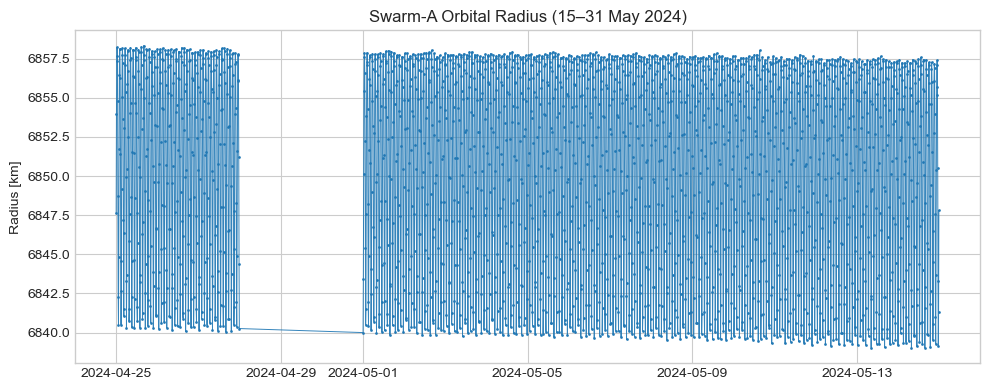

✅ Saved clean data to 'GPS_clean.parquet'
✅ Wrote column configuration to 'meas_cols.json'
✅ Clean data hash (sha1): cc146af5


In [1]:
# %% [markdown]
# # 01 – Data Exploration & Cleaning
#
# This notebook processes raw GNSS measurements for SWARM-A from **15–31 May 2024**.
#
# ### Pipeline
# 1.  Loads raw data and pivots it from a long to a wide format.
# 2.  Converts measurement units to a consistent SI standard (meters and m/s).
# 3.  Applies a 3-σ filter to flag and remove outliers based on orbital radius.
# 4.  Caches the cleaned data to a Parquet file (`GPS_clean.parquet`).
# 5.  Saves the measurement column names for downstream use (`meas_cols.json`).

# %%
# STEP 1: SETUP
# -----------------------------------------------------------------------------
import json
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Configuration ---
RAW_DATA_PATH = "GPS_measurements.parquet"
CLEAN_DATA_PATH = "GPS_clean.parquet"
COLUMN_CONFIG_PATH = "meas_cols.json"

print("✅ Setup complete.")

# %%
# STEP 2: LOAD & RESHAPE DATA
# -----------------------------------------------------------------------------
# Load raw data and pivot to a wide format
gps_long = pd.read_parquet(RAW_DATA_PATH)
gps_wide = gps_long.pivot_table(
    index="datetime",
    columns="ECEF",
    values=["position", "velocity"]
).reset_index()

# Flatten the multi-index columns (e.g., ('position', 'x') -> 'position_x')
gps_wide.columns = ["_".join(col).strip() if isinstance(col, tuple) else col for col in gps_wide.columns.values]
df = gps_wide.rename(columns={'datetime_': 'time'})

print(f"Loaded and reshaped {len(df):,} records.")

# %%
# STEP 3: CLEAN DATA & CONVERT UNITS
# -----------------------------------------------------------------------------
# Ensure consistent column order
pos_cols = sorted([c for c in df if c.startswith("position_")])
vel_cols = sorted([c for c in df if c.startswith("velocity_")])

# Standardize time and convert measurement units to SI standard (m, m/s)
df['time'] = pd.to_datetime(df['time']).dt.floor("s")
df[pos_cols] *= 1000.0  # Position: km -> m
df[vel_cols] /= 10.0    # Velocity: dm/s -> m/s

# Apply a 3-σ outlier filter based on orbital radius
r_m = np.linalg.norm(df[pos_cols], axis=1)
is_outlier = np.abs(r_m - r_m.mean()) > (3 * r_m.std())
df_clean = df[~is_outlier].reset_index(drop=True)

print(f"Removed {is_outlier.sum():,} outliers ({is_outlier.mean():.2%}).")
print(f"Clean dataset contains {len(df_clean):,} rows.")

# %%
# STEP 4: VISUALIZE & CACHE RESULTS
# -----------------------------------------------------------------------------
# Plot the orbital radius from the cleaned data (with 10-min sampling)
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 4))
r_clean_km = np.linalg.norm(df_clean[pos_cols], axis=1) / 1000
plt.plot(df_clean["time"][::600], r_clean_km[::600], lw=0.7, marker='.', markersize=2, alpha=0.9)
plt.title("Swarm-A Orbital Radius (15–31 May 2024)")
plt.ylabel("Radius [km]")
plt.tight_layout()
plt.show()

# --- Cache clean data and configuration ---
# Save the cleaned DataFrame to a Parquet file
df_clean.to_parquet(CLEAN_DATA_PATH, index=False)
print(f"✅ Saved clean data to '{CLEAN_DATA_PATH}'")

# Save the column list to a JSON file for downstream use
with open(COLUMN_CONFIG_PATH, "w") as f:
    json.dump(pos_cols + vel_cols, f, indent=2)
print(f"✅ Wrote column configuration to '{COLUMN_CONFIG_PATH}'")

# Generate and print a SHA1 hash for data verification
sha = hashlib.sha1(pd.util.hash_pandas_object(df_clean, index=True).values).hexdigest()
print(f"✅ Clean data hash (sha1): {sha[:8]}")